In [14]:
import numpy as np
import netCDF4 as nc
import h5py
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
import seaborn as sns
import matplotlib as mpl
import cv2
from datetime import datetime

# from sklearn.metrics import roc_curve

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Concatenate

# this way I do not have to reshape the data
from keras.backend import set_image_data_format, image_data_format
from tensorflow.compat.v1 import disable_eager_execution
from tensorflow import executing_eagerly
from tensorflow.python.compiler.mlcompute import mlcompute

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

set_image_data_format('channels_first')
assert image_data_format() == 'channels_first', "Plase set keras backend as channels first."

# APPLE SPECIFIC IMPLEMENTATION
disable_eager_execution()
assert executing_eagerly() is False, "Please do not set to eager execution for this program."

# Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
mlcompute.set_mlc_device(device_name='cpu')  # Available options are 'cpu', 'gpu', and 'any'.

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

# Introduction

In this notebook, some confrontation using the pre-trained classifier are performed. More specifically, I shall take the **Neural Network**, trained using images of size $120\times120$ pixels of cyclons and non-cyclons (see python scripts), and see if it can manage to identify correctly cyclon in the **simulation** data as well.

Indeed, the idea is to test the question: *can a classifier, trained on real data, be able to identify before hand the presence of cyclons?*
Before answering the question, a few key point must be considered: 
- the classifier might have some bias towards the real data
- the simulated data has a much lower resolution, which means for the same box size less information is going to be available
- a visual confrontation might be needed, in order to determine to some degreee if the classifier is missing tremendously
- the simulated data comes from a very specific model. Newer and more advanced models might allow to have both a higher resolution and better results
- the classifier was trained with both all 3 wind variables (U850, UBOT and V850) and just the U850. The one with all variables achieves slightly higher performances, but since the simulated data just has U850 (due to local disk constraints), the latter classifier shall be used.

# Preparation

Here is the code to load the real and simulated data, identify the cylon box, i.e. the location of the possible cyclon, in the simulated data, and prepare accordingly.

In [25]:
# select how many examples to be tested
HOW_MANY = 30
# (WARNING) due to some code problems, with too high
# numbers you may need to run multiple times in order
# not to have it crash

In [26]:
# FAKE DATA
print("Load fake data")
datapath = './data.nosync/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h1.U850.19200101-20051231.nc'
dataset = nc.Dataset(datapath)

# select the year 2005 (but not the last day of the year, which is not present in the real data)
U850_period_interest = dataset['U850'][(dataset['date'][:] > 20041231)
                                       & (dataset['date'][:] < 20051231)]

lon_model = dataset['lon'][:]
lat_model = dataset['lat'][:]

# REAL DATA
print("Load real data")
# this data is alreay geo-reference and prepared with the cyclon boxes
# through other scripts
hf = h5py.File("./data.nosync/georeferenced_pos.h5", 'r')

# select the dates for the period 2005
print('Prepare fake dates')
date_period_interest = dataset['date'][(dataset['date'][:] > 20041231)
                                       & (dataset['date'][:] < 20060101)]
# just have consistency accross date formats
date_fake = [
    datetime.strptime(str(date), "%Y%m%d").date()
    for date in date_period_interest
]

print("Prepare real dates")
date_real = hf['time'][()].astype("<M8[us]")
date_real = [date.astype(datetime).date() for date in date_real]

print("Select %i random real cyclons." % HOW_MANY)
# select some random indexes
idx_cyclons = sorted(
    np.random.uniform(0, len(date_real), HOW_MANY).astype(int))
# select date and cyclon image from the real data
real_images = hf['images'][idx_cyclons]
date_real = np.array(date_real)[idx_cyclons]

Load fake data
Load real data
Prepare fake dates
Prepare real dates
Select 30 random real cyclons.


In [27]:
print("Find corresponding fake image.")
# i use the date to match the images
# (IMPORTANT) The real data as 4 images per day, while the simulated just one
# nonetheless, it will be matched by the day (so up to 4 real images might have 1 
# simulated image)
# select index
idx_fake_cyclon = [
    np.where(np.array(date_fake) == dd)[0][0] for dd in date_real
]
# select image with index. Here the image is still the whole globe
fake_images = U850_period_interest[idx_fake_cyclon]
# use lat and lon to figure out the box position
# (WARNING) since the lat and lon do not precisely coincide, 
# some error, of up to 0.5, is allowed. 
# If more lat or lon are available, just select the first one
print("Cut around cyclon in fake images")
fake_images = [
    fake_image[np.where(np.isclose(lon_model, lon_min, 0.5))[0][0]:np.
               where(np.isclose(lon_model, lon_max, 0.5))[0][0],
               np.where(np.isclose(lat_model, lat_min, 0.5))[0][0]:np.
               where(np.isclose(lat_model, lat_max, 0.5))[0][0]]
    for fake_image, lat_min, lat_max, lon_min, lon_max in zip(
        fake_images, hf['lat_min'][idx_cyclons], hf['lat_max'][idx_cyclons],
        hf['lon_min'][idx_cyclons], hf['lon_max'][idx_cyclons])
]
# (NOTICE) i dati sono già ordinati
# since the simulated images have all different sizes, scale up
# to the train size (120, 120)
print('Resize to correct size')
fake_images = [
    cv2.resize(np.transpose(fake_image),
               dsize=(120, 120),
               interpolation=cv2.INTER_CUBIC) for fake_image in fake_images
]
fake_images = np.stack(fake_images, axis=0)
# the rea images have 3 channels, but the simulated ones just the U850
print('Consider only U850 channel in real images')
real_images = real_images[:,[0],:,:]
# for the neural net, I need the channel dimension
fake_images = np.expand_dims(fake_images, axis = 1)
# just a small check 
assert fake_images.shape == real_images.shape, 'Some mistake in the definition of the arrays'

Find corresponding fake image.
Cut around cyclon in fake images
Resize to correct size
Consider only U850 channel in real images


# Model confrontation

Here the code to load the correct model and test it is shown. In this case, first off the model is tested on the sample of real images; then, those images which it manages to correctly classify are selected. On this, the classifier is tested on their simulated counterpart. 

**NB**: in this case, the sample of real image might contain some train data: while this might introduce some bias, due to disk constraints it was not possible to implement a new test set (for example with different years).

In [28]:
# this few layer ahead are needed, since the VGG16 classifier takes only 3 channel images
# (I just take 3 identical channels)
print("Loading VGG (with concatenation of the single channel)")
new_input = Input(shape=fake_images.shape[1:])
img_conc = Concatenate(axis = 1)([new_input, new_input, new_input])  
VGG_model = VGG16(include_top=False, input_tensor=img_conc)
base_model = Model(inputs = VGG_model.input, outputs = VGG_model.layers[15].output)

# the model is loaded. This is the part trained locally
print("Load pre-trained CNN classifier for cyclons (U850 specific)")
U850_model = load_model("./trained_models/model_just_850")

print(
    "Since the real data depicts all cyclons, we are sure the correct class to be '1'."
)
print("Let's see a (very) bias accuracy")
print("ACC: %.3f" % (U850_model.evaluate(base_model.predict(real_images),
                                         np.zeros(len(real_images)) + 1)[-1]))

print("Let's select the cyclons the classifier manages to classify correctly.")
correct_idx = np.where(
    (U850_model.predict(base_model.predict(real_images)) + 0.5).astype(int) == 1)[0]

print("Accuracy on fake data %.3f" %(U850_model.evaluate(base_model.predict(fake_images[correct_idx]),
                    np.zeros(len(correct_idx)) + 1)[-1]))

print(
    """[COMMENT] The low accuracy score 
        on the fake images can mostly 
        be due to the incapacity of 
        the generative model, and 
        not my classifier, which on 
        real data predict correctly 
        the presence of a cyclon in 
        the same region."""
)

Loading VGG (with concatenation of the single channel)
Load pre-trained CNN classifier for cyclons (U850 specific)
Since the real data depicts all cyclons, we are sure the correct class to be '1'.
Let's see a (very) bias accuracy


/Users/leonardoalchieri/anaconda3/envs/tf_apple_2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


ACC: 0.900
Let's select the cyclons the classifier manages to classify correctly.
Accuracy on fake data 0.259
[COMMENT] The low accuracy score 
        on the fake images can mostly 
        be due to the incapacity of 
        the generative model, and 
        not my classifier, which on 
        real data predict correctly 
        the presence of a cyclon in 
        the same region.


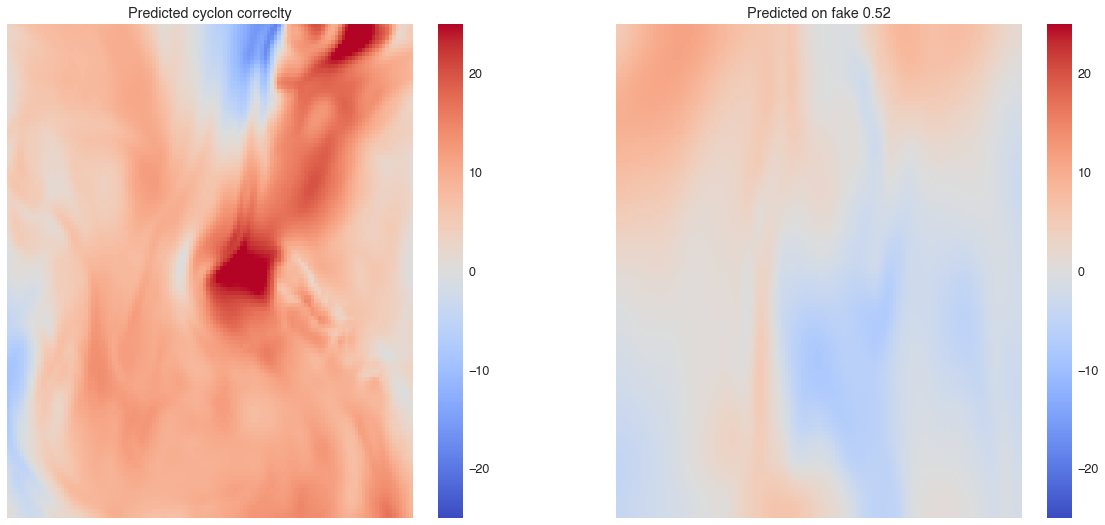

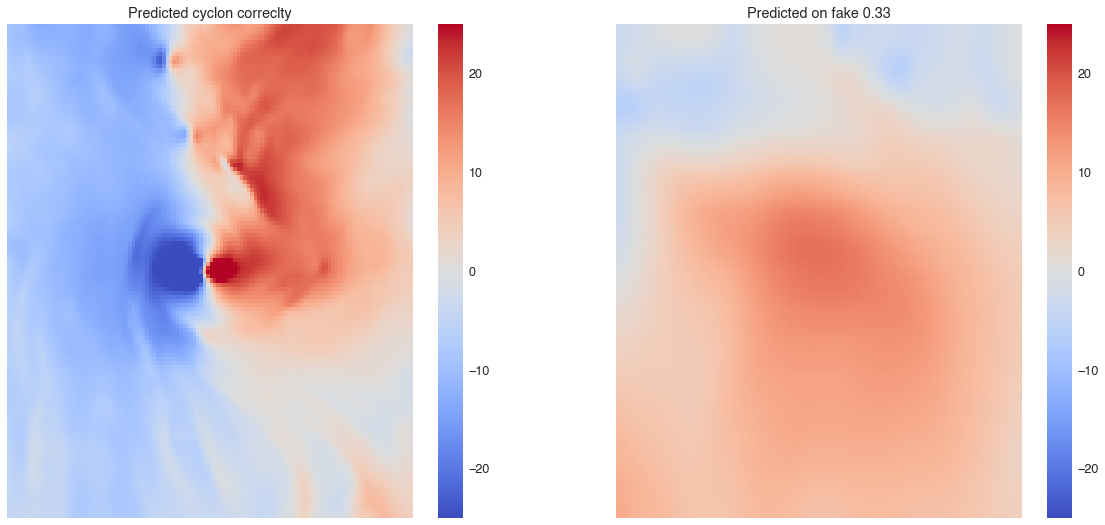

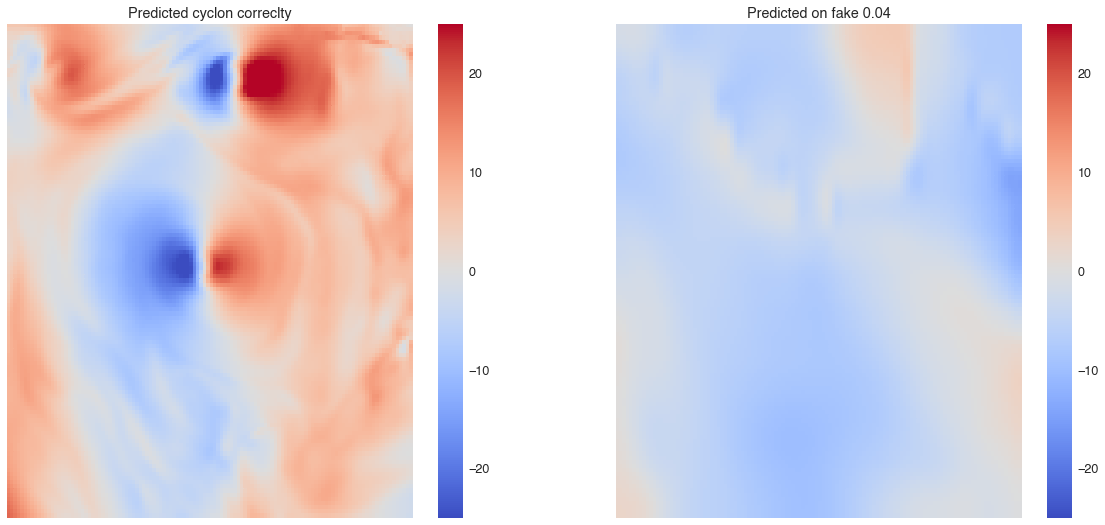

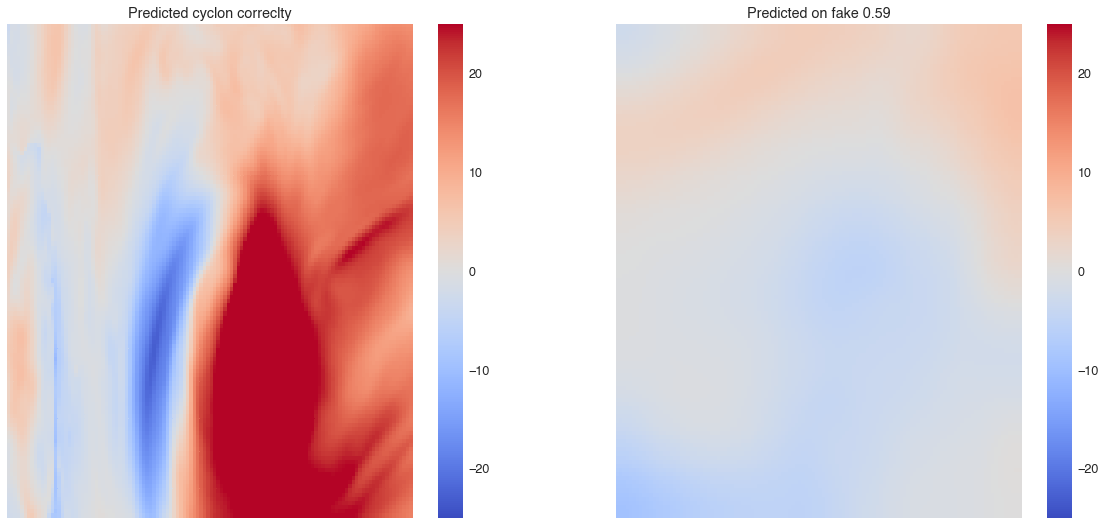

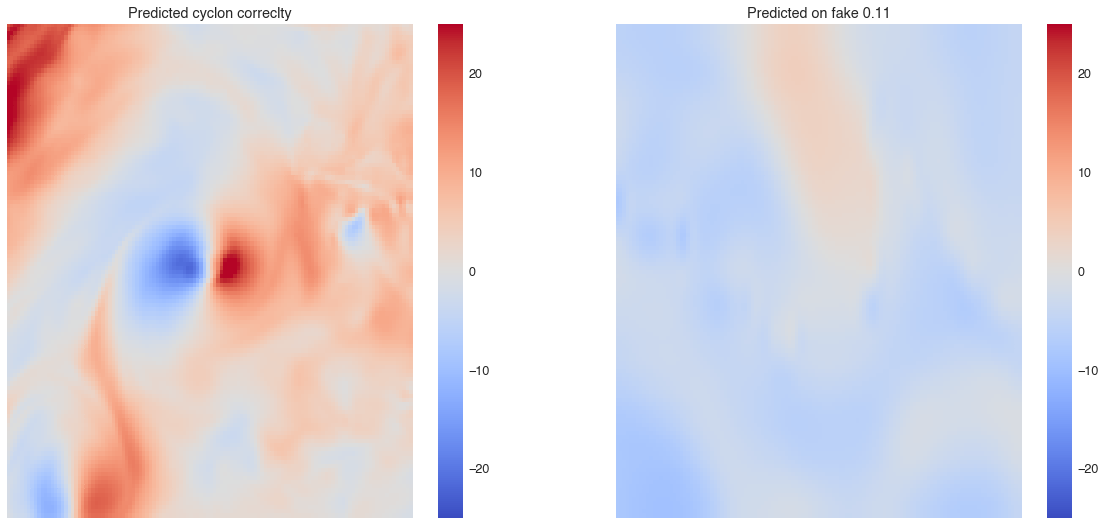

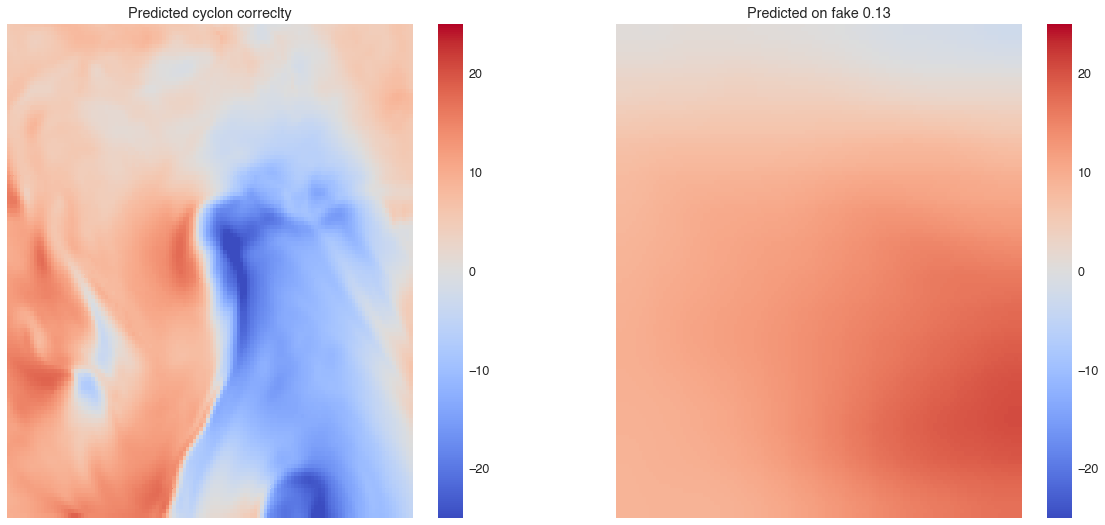

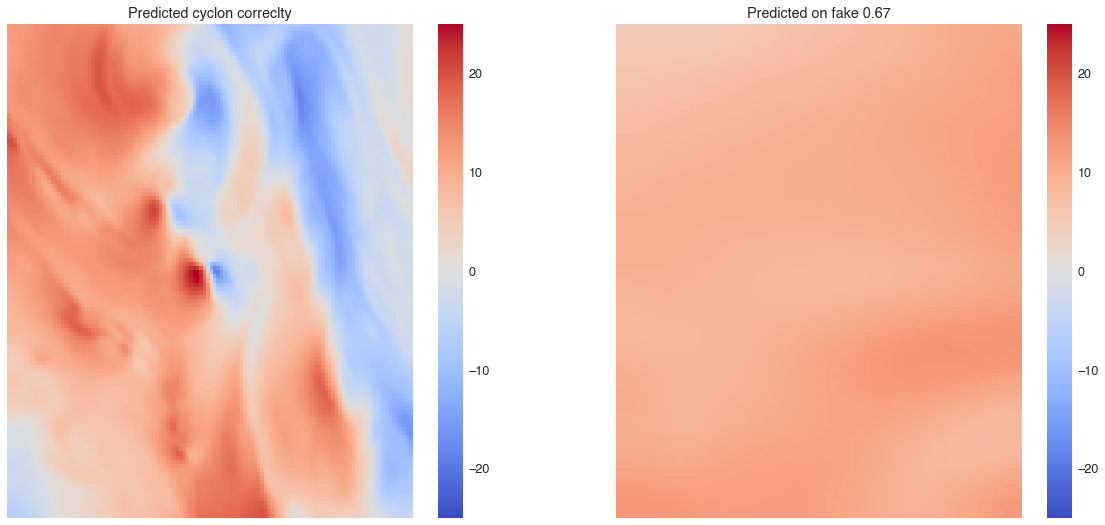

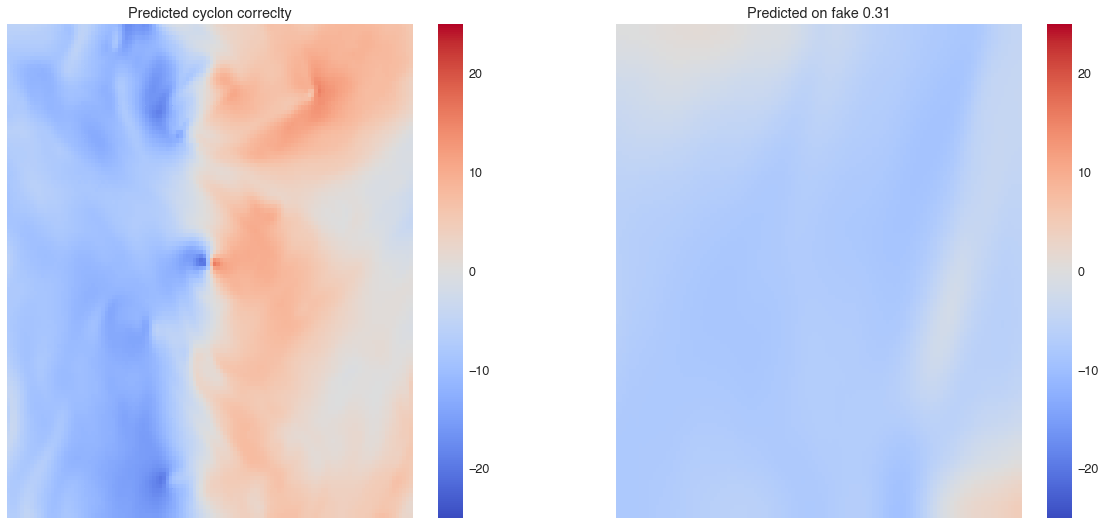

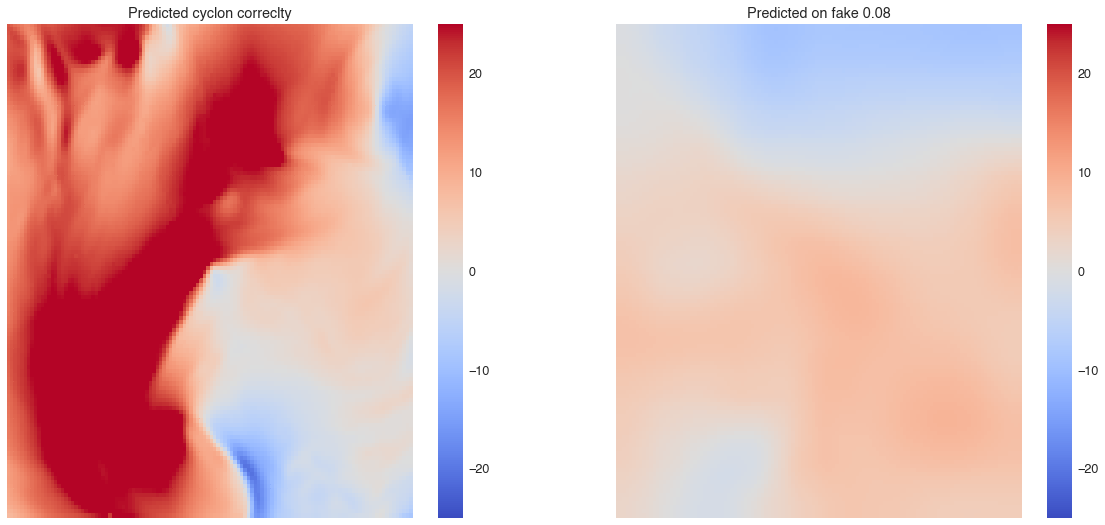

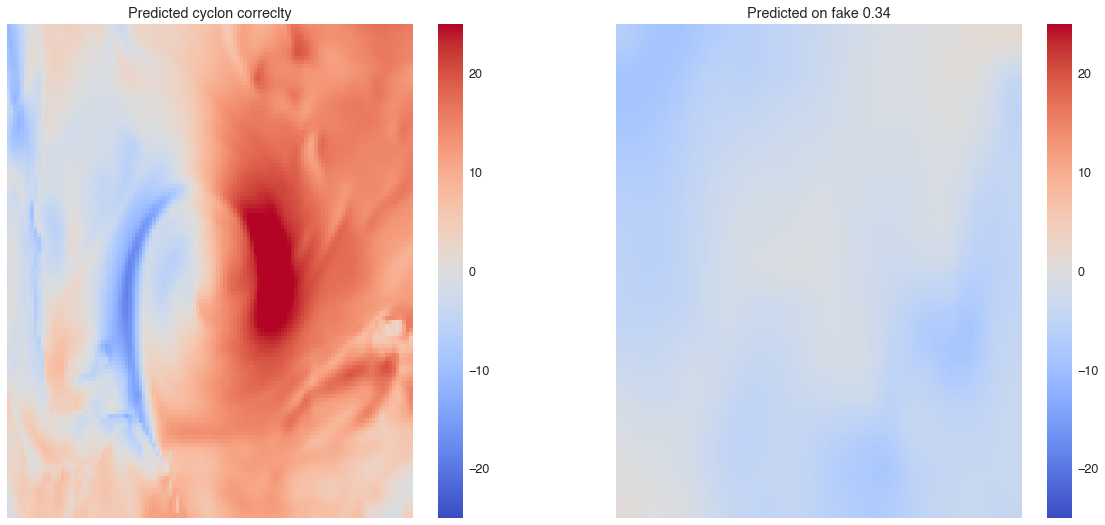

In [30]:
# plot just the first 10
for i, idx in enumerate(correct_idx):
    if i == 10:
        break
    plt.figure(figsize=(20, 20))
    plt.subplot(221)
    fig = sns.heatmap(np.transpose(real_images[idx, 0, :, :]), vmin=-25, vmax=25, cmap=mpl.cm.coolwarm)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)    
    plt.title("Predicted cyclon correclty")
    plt.subplot(222)
    fig = sns.heatmap(np.transpose(fake_images[idx, 0, :, :]), vmin=-25, vmax=25,  cmap=mpl.cm.coolwarm)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)    
    
    plt.title(
        "Predicted on fake %.2f" %
        (U850_model.predict(base_model.predict(fake_images[[idx], :, :, :]))))
    plt.show()

The most clear information that can be deduced from this result is that there is no simulated image which shows graphically, i.e. in the same manner as can be seen in the real images, the presence of a cyclon. This can be due to limitations in the simulations and limitations in the image resolution.

While this very simple experiment has large limitations, both in the train-test data and in the simulated data, it does hightlight some large concerns for the possibility of correctly identifying cyclon in a simulation. Indeed, the largest struggle might be the availabilty of better simulated data, more than a better trained network, since this latter did manage to achieve considerably good performances even if a remarkably simple training.